## **Introduction**

This notebook investigates **claim-level** veracity prediction on the **FEVER** dataset as part of a broader study on misinformation detection across multiple benchmarks. The goal is to evaluate how different modeling approaches capture the linguistic cues associated with factual correctness. The workflow includes dataset cleaning, majority-vote label consolidation, decontamination of train/validation/test splits, and systematic comparison of three baselines: TF–IDF + Complement Naive Bayes, FastText embeddings with a multilayer perceptron, and a fine-tuned XLM-RoBERTa classifier.


In [1]:
!pip install -q datasets
!pip install -q transformers
!pip install -q gensim
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset as HfDataset
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, average_precision_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
import evaluate
import random
from pprint import pprint
import os
import nltk
import gensim.downloader as api

pd.set_option('future.no_silent_downcasting', True)

nltk.download("punkt")
nltk.download("punkt_tab")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
output_dir = "/content/drive/MyDrive/misinfo_project/fever"
os.makedirs(output_dir, exist_ok=True)

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## **Dataset and Pre-processing**

The **FEVER** subset of the ComplexDataLab Misinfo_Datasets is used, containing English fact-checking claims annotated as *false*, *true*, or *unknown*. Each example provides a short **claim text** and its associated **veracity label**.

The preprocessing pipeline consists of:

* Keeping only the `claim` and `veracity` columns.
* Replacing literal `"na"` strings with missing values and removing rows with empty or invalid fields.
* Collapsing multiple annotations per claim using a **majority-vote threshold of 0.7** to resolve conflicting labels.
* Removing **duplicate claims across train/validation/test splits** to avoid leakage and ensure clean separation between datasets.

After preprocessing, the final dataset contains **109,656** training examples, **15,225** validation examples, and **29,901** test examples, with **no overlapping claims** across splits.



In [6]:
SUBSET_NAME = "fever"
TEXT_COL = "claim"
LABEL_COL = "veracity"

In [7]:
ds = load_dataset("ComplexDataLab/Misinfo_Datasets", SUBSET_NAME)
ds

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

fever/fever_train.parquet:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

fever/fever_test.parquet:   0%|          | 0.00/2.98M [00:00<?, ?B/s]

fever/fever_validation.parquet:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/129811 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/37090 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18544 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['claim', 'veracity', 'dataset', 'label', 'question', 'answer', 'positive_evidence_text', 'positive_evidence_title', 'negative_evidence_text', 'negative_evidence_title', 'split', 'source', 'source_url', 'article_content', 'article_headline', 'author', 'initial_claim', 'fact1', 'fact2', 'fact3', 'fact4', 'num_hops', 'date', 'similarity', 'like_count', 'retweet_count', 'tweet_text', 'tweet_label', 'evidence_1', 'link_evidence_1', 'source_evidence_1', 'fact_check_source', 'image', 'article_title', 'meta_data_twitter_site', 'meta_data_og_image', 'source_id', 'fact_check_url', 'language', 'tweet_id', 'subject', 'revelant_to_vaccines', 'mention_non_covid_vaccine', 'contain_misinfo_about_vaccine', 'dominant_sentiment_tweet', 'dominant_sentiment_vaccine', 'country', 'image_id', 'image_url', 'event', 'label_2', 'pos_variations', 'Q1_contain_factual_claim', 'Q2_contain_false_info', 'Q3_impact_on_public', 'Q4_harmful_to_society', 'Q5_factchecke

In [8]:
def hf_clean(ds_split, text_col=TEXT_COL, label_col=LABEL_COL):
    df = ds_split.to_pandas()

    df = df.replace("na", np.nan)

    df = df[[text_col, label_col]].dropna()
    df[text_col]  = df[text_col].astype(str).str.strip()
    df[label_col] = df[label_col].astype(str).str.strip()
    df = df[(df[text_col] != "") & (df[label_col] != "")]

    return df

In [9]:
def collapse_by_majority_label(df, text_col=TEXT_COL, label_col=LABEL_COL, min_majority=0.7):
    # count labels per claim
    label_counts = (
        df.groupby([text_col, label_col])
          .size()
          .rename("count")
          .reset_index()
    )

    # for each claim, find majority label and its proportion
    total_per_claim = label_counts.groupby(text_col)["count"].transform("sum")
    label_counts["prop"] = label_counts["count"] / total_per_claim

    majority = (label_counts.sort_values("prop", ascending=False)
                           .drop_duplicates(subset=[text_col]))

    # keep only claims where majority label has enough support
    majority = majority[majority["prop"] >= min_majority]

    clean_df = majority[[text_col, label_col]].copy()

    return clean_df

In [10]:
clean_train_df = hf_clean(ds["train"])
clean_val_df = hf_clean(ds["validation"])
clean_test_df = hf_clean(ds["test"])

In [11]:
train_df = collapse_by_majority_label(clean_train_df)
val_df = collapse_by_majority_label(clean_val_df)
test_df = collapse_by_majority_label(clean_test_df)

In [12]:
print("Original train size:", len(clean_train_df))
print("After collapsing, train size:", len(train_df))
print("Original val size  :", len(clean_val_df))
print("After collapsing, val size  :", len(val_df))
print("Original test size :", len(clean_test_df))
print("After collapsing, test size :", len(test_df))

Original train size: 115903
After collapsing, train size: 109656
Original val size  : 16558
After collapsing, val size  : 16364
Original test size : 32986
After collapsing, test size : 32293


In [13]:
train_claims = set(train_df[TEXT_COL])
val_claims   = set(val_df[TEXT_COL])
test_claims  = set(test_df[TEXT_COL])

# Pairwise overlaps
train_val_overlap  = train_claims & val_claims
train_test_overlap = train_claims & test_claims
val_test_overlap   = val_claims & test_claims

# Triple overlap (in all three splits)
all_three_overlap = train_claims & val_claims & test_claims

print("Unique claims per split:")
print(f"  Train: {len(train_claims)}")
print(f"  Val  : {len(val_claims)}")
print(f"  Test : {len(test_claims)}\n")

print("Overlapping claims:")
print(f"  Train ∩ Val      : {len(train_val_overlap)}")
print(f"  Train ∩ Test     : {len(train_test_overlap)}")
print(f"  Val ∩ Test       : {len(val_test_overlap)}")
print(f"  Train ∩ Val ∩ Test: {len(all_three_overlap)}")


Unique claims per split:
  Train: 109656
  Val  : 16364
  Test : 32293

Overlapping claims:
  Train ∩ Val      : 1139
  Train ∩ Test     : 2194
  Val ∩ Test       : 463
  Train ∩ Val ∩ Test: 265


In [14]:
def remove_split_duplicates(train_df, val_df, test_df, text_col=TEXT_COL):
    """
    Remove examples from val and test sets that appear in train set
    """
    # Get unique claims from train set
    train_claims = set(train_df[text_col])

    # Remove duplicates from validation set
    val_df_clean = val_df[~val_df[text_col].isin(train_claims)].copy()

    # Remove duplicates from test set
    test_df_clean = test_df[~test_df[text_col].isin(train_claims)].copy()

    # Also remove any overlap between val and test
    val_claims_clean = set(val_df_clean[text_col])
    test_df_clean = test_df_clean[~test_df_clean[text_col].isin(val_claims_clean)]

    print(f"Removed {len(val_df) - len(val_df_clean)} duplicates from validation set")
    print(f"Removed {len(test_df) - len(test_df_clean)} duplicates from test set")
    print(f"Final sizes - Train: {len(train_df)}, Val: {len(val_df_clean)}, Test: {len(test_df_clean)}")

    return val_df_clean, test_df_clean

In [15]:
val_df, test_df = remove_split_duplicates(train_df, val_df, test_df)

print("\nAfter deduplication:")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Removed 1139 duplicates from validation set
Removed 2392 duplicates from test set
Final sizes - Train: 109656, Val: 15225, Test: 29901

After deduplication:
Train: 109656, Val: 15225, Test: 29901


In [16]:
# Verify no overlaps remain
train_claims_final = set(train_df[TEXT_COL])
val_claims_final = set(val_df[TEXT_COL])
test_claims_final = set(test_df[TEXT_COL])

print(f"Train ∩ Val: {len(train_claims_final & val_claims_final)}")
print(f"Train ∩ Test: {len(train_claims_final & test_claims_final)}")
print(f"Val ∩ Test: {len(val_claims_final & test_claims_final)}")

Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0


In [17]:
# unique labels from train
unique_labels = sorted(train_df[LABEL_COL].unique())
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

print("Label mapping:")
print(label2id)

Label mapping:
{'false': 0, 'true': 1, 'unknown': 2}


In [18]:
# Add numeric labels
train_df["labels"] = train_df[LABEL_COL].map(label2id)
val_df["labels"] = val_df[LABEL_COL].map(label2id)
test_df["labels"] = test_df[LABEL_COL].map(label2id)

In [19]:
def label_stats(df, split_name):
    print(f"\n=== {split_name}: Label distribution ===")
    counts = df[LABEL_COL].value_counts()
    perc = (counts / len(df) * 100).round(2)
    out = pd.DataFrame({"count": counts, "percent": perc})
    print(out)
    return out

lab_train = label_stats(train_df, "Train")
lab_val = label_stats(val_df, "Validation")
lab_test = label_stats(test_df, "Test")


=== Train: Label distribution ===
          count  percent
veracity                
true      57085    52.06
unknown   28239    25.75
false     24332    22.19

=== Validation: Label distribution ===
          count  percent
veracity                
true       7796    51.21
unknown    4009    26.33
false      3420    22.46

=== Test: Label distribution ===
          count  percent
veracity                
true      15398     51.5
unknown    7686     25.7
false      6817     22.8


In [21]:
print(train_df.head())

                                                    claim veracity  labels
110584                      Ātman means soul in Sanskrit.     true       1
0       "Artist of the Year" was a name given to Danny...     true       1
1        "Beautiful" has a message of female empowerment.     true       1
2          "Beautiful" has a message of self-empowerment.     true       1
3                  "Beautiful" is about self-empowerment.     true       1


## **Evaluation Utilities**


- **Confusion matrices** (raw counts + normalized):
  - Show which pairs of labels (`false`, `true`, `unknown`) are most frequently confused.
- **Macro-F1**:
  - Averages F1 across classes and is robust to class imbalance.
- **Macro and Micro AUPRC**:
  - Evaluate how well the model’s **probability scores** rank the true labels.
- **Expected Calibration Error (ECE)**:
  - Measures how well predicted probabilities reflect actual accuracy (e.g., “are 0.8-confidence predictions correct ~80% of the time?”).
- **Error tables**:
  - For each misclassified example, store:
    - the original text,
    - ground-truth label,
    - predicted label,
    - model confidence and per-class probabilities.

These utilities are shared by all models (Complement Naive Bayes, FastText+MLP, XLM-R) so their performance and typical errors can be directly compared.


In [22]:
def plot_confusion(y_true, probs, id2label=id2label, normalize=False, title=None):
    """
    y_true: ground truth labels (numpy array)
    probs: predicted probabilities from model (numpy array)
    normalize: True → show percentages, False → raw counts
    """
    preds = probs.argmax(axis=1)

    cm = confusion_matrix(y_true, preds, normalize='true' if normalize else None)

    labels = [id2label[i] for i in sorted(id2label.keys())]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if title:
        plt.title(title)
    plt.show()

    return cm

In [23]:
CLASS_IDS = sorted(id2label.keys())

def compute_auprc(probs, y_true, class_ids=CLASS_IDS):
    """
    probs: [N, num_classes]
    y_true: [N] (int labels)
    """
    y_bin = label_binarize(y_true, classes=class_ids)  # [N, C]
    auprc_macro = average_precision_score(y_bin, probs, average="macro")
    auprc_micro = average_precision_score(y_bin, probs, average="micro")
    return auprc_macro, auprc_micro


def compute_ece(probs, y_true, n_bins=15):
    """
    Simple Expected Calibration Error (ECE).
    probs: [N, num_classes]
    y_true: [N]
    """
    preds = probs.argmax(axis=1)
    confidences = probs.max(axis=1)
    correct = (preds == y_true).astype(float)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        mask = (confidences > bins[i]) & (confidences <= bins[i+1])
        if not np.any(mask):
            continue
        bin_conf = confidences[mask].mean()
        bin_acc  = correct[mask].mean()
        bin_frac = mask.mean()
        ece += bin_frac * abs(bin_conf - bin_acc)

    return float(ece)

In [24]:
def evaluate_probs(probs, y_true, split_name, class_ids, id2label, n_bins=15):
    """
    probs: [N, num_classes]
    y_true: [N] int labels
    class_ids: list of class indices (e.g., CLASS_IDS = sorted(id2label.keys()))
    id2label: dict mapping id -> label string
    """
    preds = probs.argmax(axis=1)

    # Macro-F1
    macro_f1 = f1_score(y_true, preds, average="macro")

    # AUPRC
    auprc_macro, auprc_micro = compute_auprc(probs, y_true, class_ids=class_ids)

    # ECE
    ece = compute_ece(probs, y_true, n_bins=n_bins)

    print(f"\n=== {split_name} ===")
    print("Macro-F1     :", macro_f1)
    print("Macro AUPRC  :", auprc_macro)
    print("Micro AUPRC  :", auprc_micro)
    print("ECE          :", ece)
    print()
    print(
        classification_report(
            y_true,
            preds,
            target_names=[id2label[i] for i in class_ids],
            zero_division=0,
        )
    )

    metrics = {
        "macro_f1": macro_f1,
        "auprc_macro": auprc_macro,
        "auprc_micro": auprc_micro,
        "ece": ece,
    }

    return metrics, preds

In [25]:
def evaluate_sklearn_clf(model, X, y, split_name,
                         class_ids=CLASS_IDS, id2label=id2label, n_bins=15):
    """
    Evaluate any sklearn classifier with predict_proba.
    Returns (metrics_dict, probs, preds).
    """
    probs = model.predict_proba(X)  # [N, C]
    metrics, preds = evaluate_probs(
        probs, y, split_name,
        class_ids=class_ids,
        id2label=id2label,
        n_bins=n_bins
    )
    return metrics, probs, preds

In [26]:
def make_error_table(
    probs,
    y_true,
    texts,
    class_ids,
    id2label,
    split_name,
    model_name,
):
    """
    Build a DataFrame of misclassified examples

    probs: [N, C] numpy array of predicted probabilities
    y_true: [N] numpy array of int labels
    texts: list of raw texts (len N)
    split_name: "train" / "val" / "test"
    model_name: "TFIDF+NB" / "FT+MLP" / "XLM-R"
    """
    preds = probs.argmax(axis=1)
    confs = probs.max(axis=1)

    rows = []
    for i, (p, gt, pred, conf, text) in enumerate(
        zip(probs, y_true, preds, confs, texts)
    ):
        if gt == pred:
            continue  # keep only misclassified examples

        row = {
            "idx": i,
            "text": text,
            "actual": id2label[int(gt)],
            "pred": id2label[int(pred)],
            "conf": float(conf),
            "split": split_name,
            "model": model_name,
        }

        # Per-class probabilities
        for c in class_ids:
            row[f"p_{id2label[c]}"] = float(p[c])

        rows.append(row)

    return pd.DataFrame(rows)


def show_errors(df, actual_label, pred_label, k=5, sort_by_conf=True):
    """
    Inspect misclassifications:
    actual_label, pred_label: strings like "false", "true", "unknown"
    """
    subset = df[(df["actual"] == actual_label) & (df["pred"] == pred_label)]

    if subset.empty:
        print(f"No examples for actual={actual_label}, pred={pred_label}")
        return

    if sort_by_conf:
        subset = subset.sort_values("conf", ascending=False)

    print(f"\n=== {len(subset)} examples where actual={actual_label}, pred={pred_label} ===\n")
    for _, row in subset.head(k).iterrows():
        print(f"[idx={row['idx']}] conf={row['conf']:.3f}")
        print("TEXT:", row["text"])
        print("ACTUAL:", row["actual"], "| PRED:", row["pred"])
        print("-" * 80)

## **TF-IDF + Complement Naive Bayes**

The first model is a **TF–IDF + Complement Naive Bayes** classifier:

- Claims are represented using **unigrams and bigrams** (`ngram_range=(1, 2)`).
- The vocabulary is capped at **100,000 features** and pruned with `min_df=2`.
- **ComplementNB** is well-suited for text classification with **imbalanced classes**.

In [27]:
X_train = train_df[TEXT_COL].tolist()
y_train = train_df["labels"].to_numpy()

X_val   = val_df[TEXT_COL].tolist()
y_val   = val_df["labels"].to_numpy()

X_test  = test_df[TEXT_COL].tolist()
y_test  = test_df["labels"].to_numpy()

In [28]:
print(X_train[0])
print(y_train[0])

Ātman means soul in Sanskrit.
1


In [28]:
tfidf_nb_clf = Pipeline(
    [
        ("tfidf", TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=100_000,
            min_df=2
        )),
        ("cnb", ComplementNB())
    ]
)

In [29]:
tfidf_nb_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('cnb', ComplementNB())])

In [30]:
metrics_train_nb, train_probs_nb, train_preds_nb = evaluate_sklearn_clf(
    tfidf_nb_clf, X_train, y_train, "Train (TFIDF+NB) on Fever"
)
metrics_val_nb,   val_probs_nb,   val_preds_nb   = evaluate_sklearn_clf(
    tfidf_nb_clf, X_val,   y_val,   "Validation (TFIDF+NB) on Fever"
)
metrics_test_nb,  test_probs_nb,  test_preds_nb  = evaluate_sklearn_clf(
    tfidf_nb_clf, X_test,  y_test,  "Test (TFIDF+NB) on Fever"
)


=== Train (TFIDF+NB) on Fever ===
Macro-F1     : 0.7082801519912767
Macro AUPRC  : 0.778431245975661
Micro AUPRC  : 0.7988037024158875
ECE          : 0.2366728250454389

              precision    recall  f1-score   support

       false       0.69      0.73      0.71     24332
        true       0.78      0.80      0.79     57085
     unknown       0.67      0.60      0.63     28239

    accuracy                           0.73    109656
   macro avg       0.71      0.71      0.71    109656
weighted avg       0.73      0.73      0.73    109656


=== Validation (TFIDF+NB) on Fever ===
Macro-F1     : 0.5405812027130533
Macro AUPRC  : 0.5874407692972515
Micro AUPRC  : 0.622177323211847
ECE          : 0.09708010340816497

              precision    recall  f1-score   support

       false       0.53      0.57      0.55      3420
        true       0.64      0.68      0.66      7796
     unknown       0.45      0.38      0.41      4009

    accuracy                           0.57     15225

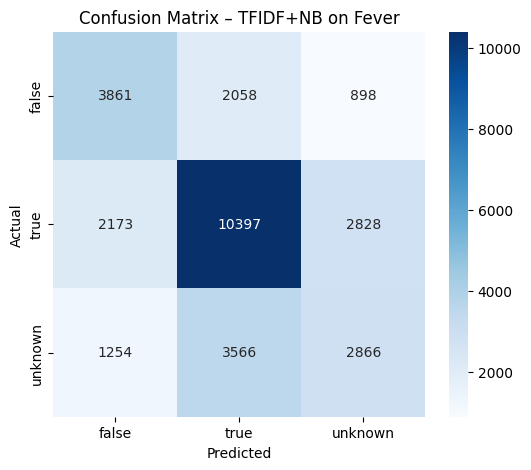

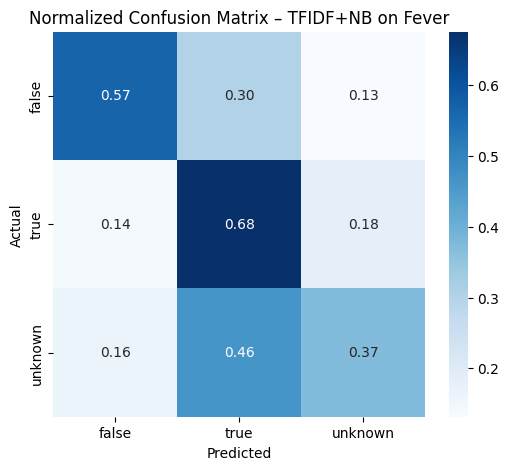

In [31]:
cm_nb = plot_confusion(
    y_true=y_test,
    probs=test_probs_nb,
    title="Confusion Matrix – TFIDF+NB on Fever"
)

cm_nb_norm = plot_confusion(
    y_true=y_test,
    probs=test_probs_nb,
    normalize=True,
    title="Normalized Confusion Matrix – TFIDF+NB on Fever"
)

In [39]:
errors_nb_test = make_error_table(
    probs=test_probs_nb,
    y_true=y_test,
    texts=X_test,
    class_ids=CLASS_IDS,
    id2label=id2label,
    split_name="test",
    model_name="TFIDF+NB"
)

In [40]:
print("Total misclassified examples:", len(errors_nb_test))

Total misclassified examples: 12777


In [41]:
errors_nb_test.head()

,idx,text,actual,pred,conf,split,model,p_false,p_true,p_unknown
0,0,Ātman means soul.,true,false,0.451043,test,TFIDF+NB,0.451043,0.245922,0.303035
1,3,"""Beautiful"" is widely unpopular among the gay ...",false,true,0.383474,test,TFIDF+NB,0.288192,0.383474,0.328334
2,4,"""Big George"" is George Foreman's nickname.",true,unknown,0.397002,test,TFIDF+NB,0.333337,0.269660,0.397002
3,7,"""I Feel for You"" by Chaka Khan was released fi...",false,unknown,0.490588,test,TFIDF+NB,0.294043,0.215369,0.490588
4,9,"""Love the Way You Lie"" collected five Grammy n...",true,false,0.441286,test,TFIDF+NB,0.441286,0.306777,0.251936


In [42]:
nb_errors_path = os.path.join(output_dir, "fever_nb_test_errors.csv")
errors_nb_test.to_csv(nb_errors_path, index=False)

print("Saved NB test errors to:", nb_errors_path)

Saved NB test errors to: /content/drive/MyDrive/misinfo_project/fever/fever_nb_test_errors.csv


## **FastText Embeddings + MLP**

The second model is a **shallow neural model** that uses pre-trained **FastText** word embeddings combined with a small MLP:

1. **Tokenization & Embeddings**
   - Each claim is tokenized with `nltk.word_tokenize`.
   - **Only alphabetic** tokens are retained, and a **300-dimensional** FastText vector is obtained for each token.
   - Token vectors are **averaged** to produce a single sentence embedding per claim, followed by **L2-normalization**.

2. **MLP Architecture**
   - Input: 300-dim sentence vector.
   - Two hidden layers of size 256 and 128 with **ReLU** activations.
   - **Dropout (0.3)** after each hidden layer to reduce overfitting.
   - Output: 3-way softmax for `false`, `true`, `unknown`.

3. **Training Details**
   - Loss: Cross-entropy with **class weights** derived from the training label distribution to counter imbalance.
   - Optimizer: Adam with learning rate `1e-3`.
   - Strategy: up to **100 epochs** with **early stopping** based on validation macro-F1.

After training, the model is evaluated with the same metrics (Macro-F1, AUPRC, ECE, confusion matrices, error tables) to see how much a shallow neural approach improves over the lexical baseline.


In [43]:
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [44]:
def tokenize(text):
    tokens = nltk.word_tokenize(text.lower())
    return [token for token in tokens if token.isalpha()]

In [45]:
def sent_to_vec(tokens, model, dim):
    vecs = [model[w] for w in tokens if w in model]
    if not vecs:
        return np.zeros(dim, dtype=np.float32)
    v = np.mean(vecs, axis=0)

    norm = np.linalg.norm(v)
    if norm > 0:
        v = v / norm

    return v.astype(np.float32)

def build_features(df, text_col, model, dim):
    X = np.vstack([
        sent_to_vec(tokenize(t), model, dim)
        for t in df[text_col].tolist()
    ])
    y = df["labels"].to_numpy()
    return X, y

In [46]:
X_train_ft, y_train_ft = build_features(train_df, TEXT_COL, fasttext_model, 300)
X_val_ft, y_val_ft = build_features(val_df, TEXT_COL, fasttext_model, 300)
X_test_ft, y_test_ft = build_features(test_df, TEXT_COL, fasttext_model, 300)

In [47]:
X_train_ft.shape

(109656, 300)

In [48]:
class FT_Dataset(TorchDataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __getitems__(self, indices):
        return [self.__getitem__(i) for i in indices]

train_ds = FT_Dataset(X_train_ft, y_train_ft)
val_ds = FT_Dataset(X_val_ft, y_val_ft)
test_ds = FT_Dataset(X_test_ft, y_test_ft)

In [49]:
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

In [50]:
class FastTextMLP(nn.Module):
    def __init__(self, input_dim=300, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

In [29]:
num_classes = len(CLASS_IDS)

class_counts = np.bincount(y_train, minlength=num_classes).astype(np.float32)
print("Counts:", class_counts)

# inverse-frequency style weights
class_weights = class_counts.sum() / (num_classes * class_counts)
print("Weights:", class_weights)

class_weights_t = torch.tensor(class_weights, dtype=torch.float32).to(device)

Counts: [24332. 57085. 28239.]
Weights: [1.5022193 0.6403083 1.2943801]


In [52]:
model = FastTextMLP().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_t)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [53]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(y.cpu().numpy())
            total_loss += loss.item()
    return (total_loss / len(loader),
            np.vstack(all_probs),
            np.concatenate(all_labels))


In [54]:
best_f1 = 0.0
best_val_loss = float("inf")
patience = 10
wait = 0
EPOCHS = 100
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader)
    val_loss, val_probs, val_labels = eval_epoch(model, val_loader)
    val_preds = val_probs.argmax(axis=1)
    val_macro_f1 = f1_score(val_labels, val_preds, average="macro")

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Macro F1: {val_macro_f1:.4f}")

    if val_macro_f1 > best_f1:
        best_f1 = val_macro_f1
        wait = 0
        best_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)

Epoch 01 | Train Loss: 1.0082 | Val Loss: 0.9637 | Val Macro F1: 0.4797
Epoch 02 | Train Loss: 0.9623 | Val Loss: 0.9615 | Val Macro F1: 0.4750
Epoch 03 | Train Loss: 0.9484 | Val Loss: 0.9373 | Val Macro F1: 0.5126
Epoch 04 | Train Loss: 0.9369 | Val Loss: 0.9319 | Val Macro F1: 0.4832
Epoch 05 | Train Loss: 0.9281 | Val Loss: 0.9242 | Val Macro F1: 0.5000
Epoch 06 | Train Loss: 0.9206 | Val Loss: 0.9169 | Val Macro F1: 0.5204
Epoch 07 | Train Loss: 0.9126 | Val Loss: 0.9143 | Val Macro F1: 0.5224
Epoch 08 | Train Loss: 0.9064 | Val Loss: 0.9123 | Val Macro F1: 0.5071
Epoch 09 | Train Loss: 0.8994 | Val Loss: 0.9083 | Val Macro F1: 0.5215
Epoch 10 | Train Loss: 0.8929 | Val Loss: 0.9049 | Val Macro F1: 0.5166
Epoch 11 | Train Loss: 0.8868 | Val Loss: 0.9033 | Val Macro F1: 0.5226
Epoch 12 | Train Loss: 0.8812 | Val Loss: 0.9079 | Val Macro F1: 0.5215
Epoch 13 | Train Loss: 0.8740 | Val Loss: 0.9012 | Val Macro F1: 0.5312
Epoch 14 | Train Loss: 0.8683 | Val Loss: 0.9029 | Val Macro F1:

<All keys matched successfully>

In [55]:
train_loss, train_probs, train_labels = eval_epoch(model, train_loader)
val_loss, val_probs,   val_labels   = eval_epoch(model, val_loader)
test_loss,  test_probs,  test_labels  = eval_epoch(model, test_loader)

print(f"\nTrain loss: {train_loss:.4f}")
metrics_train_mlp = evaluate_probs(train_probs, train_labels, "Train (FT+MLP)  on Fever", CLASS_IDS, id2label, n_bins=15)

print(f"\nValidation loss: {val_loss:.4f}")
metrics_val_mlp   = evaluate_probs(val_probs,   val_labels,   "Validation (FT+MLP)  on Fever", CLASS_IDS, id2label, n_bins=15)

print(f"\nTest loss: {test_loss:.4f}")
metrics_test_mlp  = evaluate_probs(test_probs,  test_labels,  "Test (FT+MLP) on Fever", CLASS_IDS, id2label, n_bins=15)


Train loss: 0.7175

=== Train (FT+MLP)  on Fever ===
Macro-F1     : 0.6560797973629313
Macro AUPRC  : 0.7434257619051913
Micro AUPRC  : 0.7535241260444601
ECE          : 0.05317044770477585

              precision    recall  f1-score   support

       false       0.61      0.77      0.68     24332
        true       0.77      0.66      0.71     57085
     unknown       0.56      0.59      0.57     28239

    accuracy                           0.67    109656
   macro avg       0.65      0.67      0.66    109656
weighted avg       0.68      0.67      0.67    109656


Validation loss: 0.9274

=== Validation (FT+MLP)  on Fever ===
Macro-F1     : 0.5467266803016033
Macro AUPRC  : 0.5970677779849539
Micro AUPRC  : 0.6174401193901368
ECE          : 0.04401829502461189

              precision    recall  f1-score   support

       false       0.51      0.64      0.57      3420
        true       0.68      0.58      0.62      7796
     unknown       0.43      0.46      0.45      4009

    acc

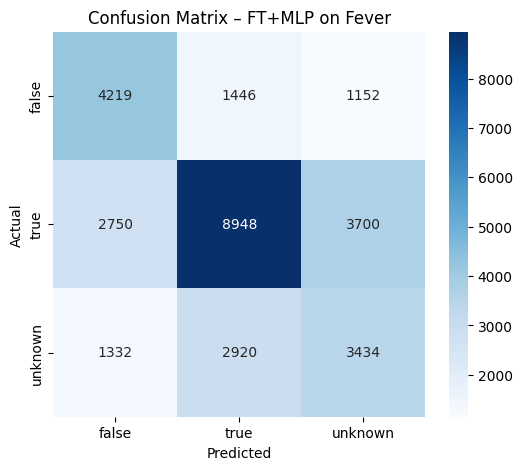

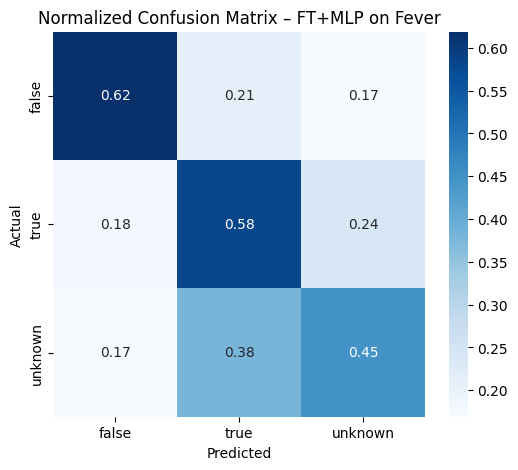

In [56]:
cm_ft = plot_confusion(
    y_true=test_labels,
    probs=test_probs,
    title="Confusion Matrix – FT+MLP on Fever"
)

cm_ft_norm = plot_confusion(
    y_true=test_labels,
    probs=test_probs,
    normalize=True,
    title="Normalized Confusion Matrix – FT+MLP on Fever"
)

In [57]:
errors_FT_MLP_test = make_error_table(
    probs=test_probs,
    y_true=test_labels,
    texts=test_df[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    split_name="test",
    model_name="FastText+MLP"
)

In [58]:
FT_MLP_errors_path = os.path.join(output_dir, "fever_FT_MLP_test_errors.csv")
errors_FT_MLP_test.to_csv(FT_MLP_errors_path, index=False)

print("Saved FT+MLP test errors to:", FT_MLP_errors_path)

Saved FT+MLP test errors to: /content/drive/MyDrive/misinfo_project/fever/fever_FT_MLP_test_errors.csv


In [59]:
errors_FT_MLP_test.head()

,idx,text,actual,pred,conf,split,model,p_false,p_true,p_unknown
0,1,"""Beautiful"" has a message in its lyrics.",true,unknown,0.559537,test,FastText+MLP,0.116652,0.323811,0.559537
1,2,"""Beautiful"" is a gay anthem.",true,unknown,0.604109,test,FastText+MLP,0.200666,0.195225,0.604109
2,3,"""Beautiful"" is widely unpopular among the gay ...",false,unknown,0.682212,test,FastText+MLP,0.086598,0.231190,0.682212
3,6,"""Eyes Wide Open"" was a Sabrina Carpenter album.",true,unknown,0.406754,test,FastText+MLP,0.210864,0.382383,0.406754
4,7,"""I Feel for You"" by Chaka Khan was released fi...",false,unknown,0.452608,test,FastText+MLP,0.343008,0.204385,0.452608


In [60]:
print("Total misclassified examples:", len(errors_FT_MLP_test))

Total misclassified examples: 13300


## **Fine-Tuning XLM-RoBERTa**

The final baseline uses a **transformer-based model**, `xlm-roberta-base`, fine-tuned on the FEVER dataset.

1. **HuggingFace Dataset Conversion**

   * The cleaned pandas DataFrames are converted into HuggingFace `Dataset` objects with the following fields:

     * `text` – the claim,
     * `labels` – the encoded veracity label.

2. **Tokenization**

   * The XLM-R tokenizer is applied with:

     * `max_length = 128`,
     * `padding = "max_length"`,
     * `truncation = True`.
   * Each instance is transformed into `(input_ids, attention_mask, labels)` in PyTorch format.

3. **Model and Training Setup**

   * The base architecture is `xlm-roberta-base`, loaded through `AutoModelForSequenceClassification` with a classification head for 3 labels.
   * A custom `WeightedTrainer` is used, which:

     * applies **class weights** within the cross-entropy loss,
     * computes evaluation metrics such as accuracy, macro-F1, macro/micro AUPRC, and ECE during training.
   * Training arguments include:

     * `learning_rate = 2e-5`,
     * `batch_size = 16`,
     * `num_train_epochs = 5`,
     * `warmup_ratio = 0.1`,
     * `weight_decay = 0.01`,
     * evaluation performed at the end of each epoch.

4. **Evaluation**

   - After fine-tuning, the model is evaluated on the train, validation, and test splits using the shared evaluation utilities.
   - Confusion matrices and detailed error tables are generated for the misclassified test examples.

This setup enables direct comparison between **lexical**, **shallow neural**, and **transformer-based** approaches under a unified evaluation framework.


**Build HuggingFace Dataset objects from the cleaned dataframes**

In [30]:
train_hf = HfDataset.from_pandas(train_df[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
val_hf = HfDataset.from_pandas(val_df[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
test_hf = HfDataset.from_pandas(test_df[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))

In [31]:
print(train_hf[0])

{'text': 'Ātman means soul in Sanskrit.', 'labels': 1, '__index_level_0__': 110584}


**Tokenizer and encodings**

In [32]:
MODEL_NAME = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
  return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )


train_encodings = train_hf.map(tokenize, batched=True)
val_encodings = val_hf.map(tokenize, batched=True)
test_encodings = test_hf.map(tokenize, batched=True)


train_encodings.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_encodings.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_encodings.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/109656 [00:00<?, ? examples/s]

Map:   0%|          | 0/15225 [00:00<?, ? examples/s]

Map:   0%|          | 0/29901 [00:00<?, ? examples/s]

In [33]:
print(train_encodings[0])

{'labels': tensor(1), 'input_ids': tensor([    0, 91360,    18,   669, 26950, 57289,    23,  1735,     7, 31434,
            5,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1, 

**Define model**

In [34]:
num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
metric_acc = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    macro_f1 = f1_score(labels, preds, average="macro")

    probs = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()

    auprc_macro, auprc_micro = compute_auprc(probs, labels, class_ids=CLASS_IDS)
    ece = compute_ece(probs, labels, n_bins=15)

    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_auprc": auprc_macro,
        "micro_auprc": auprc_micro,
        "ece": ece,
    }

In [36]:
def trainer_eval_with_report(trainer, dataset, split_name):
    out = trainer.predict(dataset)
    logits = out.predictions
    y_true = out.label_ids
    probs = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()
    metrics, preds = evaluate_probs(
        probs, y_true,
        split_name,
        class_ids=CLASS_IDS,
        id2label=id2label,
        n_bins=15
    )
    return metrics, probs, y_true

In [37]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss = F.cross_entropy(
            logits, labels,
            weight=self.class_weights.to(logits.device) if self.class_weights is not None else None
        )

        return (loss, outputs) if return_outputs else loss

In [38]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/misinfo_project/bert_models/fever_xlmr",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=False,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=200,
    report_to="none",
    save_total_limit=1
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,
    eval_dataset=val_encodings,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_t
)

/tmp/ipython-input-844214281.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Auprc,Micro Auprc,Ece
1,0.824200,0.829465,0.644729,0.609188,0.678827,0.713910,0.025467
2,0.760600,0.786677,0.661281,0.640781,0.707452,0.729320,0.038913
3,0.720000,0.778326,0.652414,0.635547,0.717480,0.727949,0.065679
4,0.641200,0.803201,0.660558,0.642838,0.719892,0.734199,0.097628
5,0.579300,0.846678,0.673432,0.651025,0.718193,0.737816,0.114057


TrainOutput(global_step=34270, training_loss=0.7295488730999135, metrics={'train_runtime': 3227.8877, 'train_samples_per_second': 169.857, 'train_steps_per_second': 10.617, 'total_flos': 3.606495616797696e+16, 'train_loss': 0.7295488730999135, 'epoch': 5.0})

In [40]:
metrics_train_xlmr = trainer_eval_with_report(trainer, train_encodings, "Train (XLM-R) on Fever")
metrics_val_xlmr = trainer_eval_with_report(trainer, val_encodings,  "Validation (XLM-R) on Fever")
metrics_test_xlmr = trainer_eval_with_report(trainer, test_encodings, "Test (XLM-R) on Fever")


=== Train (XLM-R) on Fever ===
Macro-F1     : 0.8014197526402634
Macro AUPRC  : 0.8817349137586238
Micro AUPRC  : 0.8944040394862913
ECE          : 0.0075368721978734225

              precision    recall  f1-score   support

       false       0.74      0.86      0.79     24332
        true       0.88      0.83      0.85     57085
     unknown       0.77      0.74      0.76     28239

    accuracy                           0.81    109656
   macro avg       0.80      0.81      0.80    109656
weighted avg       0.82      0.81      0.82    109656




=== Validation (XLM-R) on Fever ===
Macro-F1     : 0.6510245303758423
Macro AUPRC  : 0.7181927204010442
Micro AUPRC  : 0.7378158832199257
ECE          : 0.11405702372489893

              precision    recall  f1-score   support

       false       0.61      0.72      0.66      3420
        true       0.76      0.73      0.74      7796
     unknown       0.57      0.53      0.55      4009

    accuracy                           0.67     15225
   macro avg       0.65      0.66      0.65     15225
weighted avg       0.68      0.67      0.67     15225




=== Test (XLM-R) on Fever ===
Macro-F1     : 0.644612632130369
Macro AUPRC  : 0.7095997078977354
Micro AUPRC  : 0.7321339403959464
ECE          : 0.12055351145032024

              precision    recall  f1-score   support

       false       0.61      0.70      0.65      6817
        true       0.76      0.72      0.74     15398
     unknown       0.55      0.54      0.54      7686

    accuracy                           0.67     29901
   macro avg       0.64      0.65      0.64     29901
weighted avg       0.67      0.67      0.67     29901



In [41]:
test_output = trainer.predict(test_encodings)

logits_xlmr = test_output.predictions
test_labels_xlmr = test_output.label_ids
test_probs_xlmr = torch.softmax(torch.tensor(logits_xlmr), dim=-1).cpu().numpy()

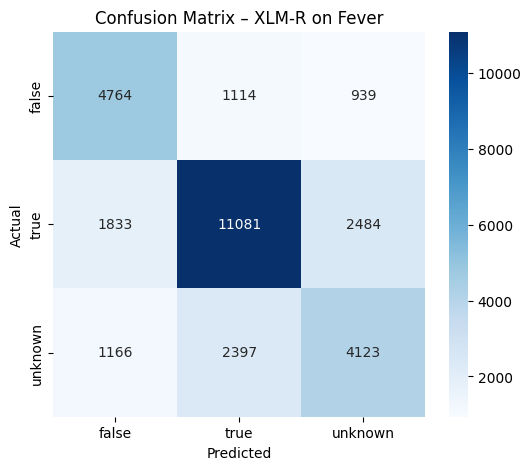

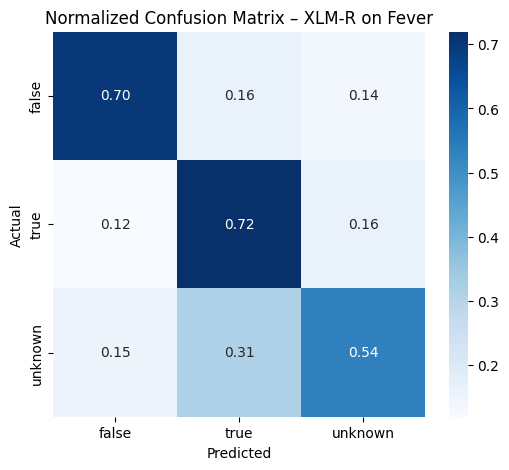

In [42]:
cm_xlmr = plot_confusion(
    y_true=test_labels_xlmr,
    probs=test_probs_xlmr,
    title="Confusion Matrix – XLM-R on Fever"
)

cm_xlmr_norm = plot_confusion(
    y_true=test_labels_xlmr,
    probs=test_probs_xlmr,
    normalize=True,
    title="Normalized Confusion Matrix – XLM-R on Fever"
)

In [43]:
errors_xlmr_test = make_error_table(
    probs=test_probs_xlmr,
    y_true=test_labels_xlmr,
    texts=test_df[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    split_name="test",
    model_name="XLM-R",
)

In [44]:
errors_xlmr_test.head()

,idx,text,actual,pred,conf,split,model,p_false,p_true,p_unknown
0,0,Ātman means soul.,true,false,0.532107,test,XLM-R,0.532107,0.172359,0.295534
1,2,"""Beautiful"" is a gay anthem.",true,false,0.817682,test,XLM-R,0.817682,0.042578,0.139740
2,15,1.7% of water are made out of salt.,unknown,true,0.805370,test,XLM-R,0.099292,0.805370,0.095338
3,21,100 Greatest of All Time was first aired by th...,true,false,0.532177,test,XLM-R,0.532177,0.406503,0.061320
4,23,12 Years a Slave was a movie produced by Brad ...,true,false,0.913590,test,XLM-R,0.913590,0.027180,0.059230


In [45]:
XLMR_errors_path = os.path.join(output_dir, "fever_XLMR_test_errors.csv")
errors_xlmr_test.to_csv(XLMR_errors_path, index=False)

print("Saved XLMR test errors to:", XLMR_errors_path)

Saved XLMR test errors to: /content/drive/MyDrive/misinfo_project/fever/fever_XLMR_test_errors.csv


## **Error Analysis Across Models**

To complement aggregate metrics, qualitative error analysis is conducted for all models.

* For each model (TF–IDF+NB, FastText+MLP, and XLM-R), the saved **test-set error tables** are loaded.
* The frequency of each misclassification pair `(actual_label → predicted_label)` is summarized.
* High-confidence errors—cases where the predicted probability is high but the prediction is incorrect—are inspected.
* Representative examples are examined for the most common confusion patterns (e.g., `unknown → true`, `true → false`).

This analysis helps identify:

* whether certain labels are systematically confused,
* whether high-confidence mistakes involve patterns such as **negation**, **subtle phrasing**, or **world-knowledge requirements**,
* and whether XLM-R reduces specific error types relative to the lexical or shallow neural baselines.




In [52]:
def summarize_errors(df):
    print("\n=== Error Counts by (actual → pred) ===")
    print(df.groupby(["actual", "pred"]).size())

    print("\n=== Top 10 high-confidence wrong predictions ===")
    print(
        df.sort_values("conf", ascending=False)
          .head(10)[["idx", "text", "actual", "pred", "conf"]]
    )

In [53]:
def inspect_top_error_pairs(df, top_n=3, k=5):
    pair_counts = (
        df.groupby(["actual", "pred"]).size()
          .sort_values(ascending=False)
          .head(top_n)
    )

    print("\nTop error pairs:")
    print(pair_counts)

    for (actual, pred), _ in pair_counts.items():
        show_errors(df, actual_label=actual, pred_label=pred, k=k)


In [49]:
errors_nb_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/fever/fever_nb_test_errors.csv")
errors_FT_MLP_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/fever/fever_FT_MLP_test_errors.csv")
errors_xlmr_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/fever/fever_XLMR_test_errors.csv")

In [50]:
print("Total misclassified examples for NB:", len(errors_nb_test))
print("Total misclassified examples for FT+MLP:", len(errors_FT_MLP_test))
print("Total misclassified examples for XLM-R:", len(errors_xlmr_test))

Total misclassified examples for NB: 12777
Total misclassified examples for FT+MLP: 13300
Total misclassified examples for XLM-R: 9933


In [54]:
summarize_errors(errors_nb_test)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       2058
         unknown     898
true     false      2173
         unknown    2828
unknown  false      1254
         true       3566
dtype: int64

=== Top 10 high-confidence wrong predictions ===
         idx                                               text   actual  \
3228    7550    Emily Ratajkowsi refused to ever be an actress.  unknown   
11829  27655      Tiger Woods is incapable of winning anything.  unknown   
3959    9362   Glee failed to ever receive an award nomination.     true   
895     2089  Arnold Schwarzenegger was incapable of being i...     true   
7424   17410         Naruto is incapable of having a last name.  unknown   
7029   16502  Michael Keaton has avoided directing his entir...  unknown   
4732   11122     Inception was unable to cast Marion Cotillard.     true   
3231    7555  Emily Dickinson is incapable of having a middl...  unknown   
12441  29082  Walt Disney was completely unre

In [55]:
inspect_top_error_pairs(errors_nb_test, top_n=3, k=5)


Top error pairs:
actual   pred   
unknown  true       3566
true     unknown    2828
         false      2173
dtype: int64

=== 3566 examples where actual=unknown, pred=true ===

[idx=15950] conf=0.814
TEXT: Marta Kauffman is a writer on a TV show.
ACTUAL: unknown | PRED: true
--------------------------------------------------------------------------------
[idx=10612] conf=0.780
TEXT: How to Lose Friends & Alienate People stars an english actor.
ACTUAL: unknown | PRED: true
--------------------------------------------------------------------------------
[idx=27438] conf=0.764
TEXT: There is a popular culture category for entertainment.
ACTUAL: unknown | PRED: true
--------------------------------------------------------------------------------
[idx=1452] conf=0.764
TEXT: An example of a real number is pi.
ACTUAL: unknown | PRED: true
--------------------------------------------------------------------------------
[idx=1931] conf=0.762
TEXT: Aparshakti Khurana made an appearance in Dang

In [56]:
summarize_errors(errors_FT_MLP_test)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       1446
         unknown    1152
true     false      2750
         unknown    3700
unknown  false      1332
         true       2920
dtype: int64

=== Top 10 high-confidence wrong predictions ===
         idx                                              text   actual  \
4732   10777                          IMDb is not user-edited.     true   
12330  27755         Tim Rice wrote anything except a musical.     true   
3118    7099              Eazy-E only performed as a solo act.     true   
6240   14188           Lana Del Rey released an album Tropico.    false   
8310   18790             Pat Riley refused to play basketball.  unknown   
4749   10812     Iain Glen is anything but a television actor.     true   
735     1691             Angelsberg is not adjacent to a lake.  unknown   
7579   17253                         Mukesh Ambani is a squid.  unknown   
13184  29621    Woodrow Wilson did not establish Wilso

In [57]:
inspect_top_error_pairs(errors_FT_MLP_test, top_n=3, k=5)


Top error pairs:
actual   pred   
true     unknown    3700
unknown  true       2920
true     false      2750
dtype: int64

=== 3700 examples where actual=true, pred=unknown ===

[idx=21521] conf=0.985
TEXT: Seiko sells watches.
ACTUAL: true | PRED: unknown
--------------------------------------------------------------------------------
[idx=18885] conf=0.974
TEXT: Paul McCartney is a dad.
ACTUAL: true | PRED: unknown
--------------------------------------------------------------------------------
[idx=21137] conf=0.966
TEXT: Samuel L. Jackson starred in Snakes on a Plane.
ACTUAL: true | PRED: unknown
--------------------------------------------------------------------------------
[idx=8926] conf=0.953
TEXT: General Motors sells assembled vehicles.
ACTUAL: true | PRED: unknown
--------------------------------------------------------------------------------
[idx=15348] conf=0.950
TEXT: Machete appears in a fake trailer.
ACTUAL: true | PRED: unknown
--------------------------------------

In [58]:
summarize_errors(errors_xlmr_test)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       1114
         unknown     939
true     false      1833
         unknown    2484
unknown  false      1166
         true       2397
dtype: int64

=== Top 10 high-confidence wrong predictions ===
        idx                                               text actual  \
6698  20349  Ricky Martin has released several albums in Sp...   true   
4455  13435  Kangana Ranaut recieved two National Film Awar...   true   
4153  12507  Joaquin Phoenix is a vegan and has been since ...   true   
7985  24212                 The Bengal tiger is from a region.   true   
6897  21003                        Sage Stallone was a father.   true   
4698  14161          Lady Gaga was born March 28, 1986 at 5pm.   true   
4049  12146                   Jeffrey Dahmer was a vegetarian.  false   
1676   4975  Christian Bale starred in a film with Kate Bec...   true   
3399  10137  Hayley Atwell's middle name is Elizabeth, whic...   true   

In [59]:
inspect_top_error_pairs(errors_xlmr_test, top_n=3, k=5)


Top error pairs:
actual   pred   
true     unknown    2484
unknown  true       2397
true     false      1833
dtype: int64

=== 2484 examples where actual=true, pred=unknown ===

[idx=20349] conf=0.991
TEXT: Ricky Martin has released several albums in Spanish.
ACTUAL: true | PRED: unknown
--------------------------------------------------------------------------------
[idx=13435] conf=0.991
TEXT: Kangana Ranaut recieved two National Film Awards for Best Actress in a row.
ACTUAL: true | PRED: unknown
--------------------------------------------------------------------------------
[idx=12507] conf=0.991
TEXT: Joaquin Phoenix is a vegan and has been since he was three years old.
ACTUAL: true | PRED: unknown
--------------------------------------------------------------------------------
[idx=24212] conf=0.991
TEXT: The Bengal tiger is from a region.
ACTUAL: true | PRED: unknown
--------------------------------------------------------------------------------
[idx=21003] conf=0.991
TEXT: Sa